# Network Intrusion Detection
> [github.com/alik604](github.com/alik604)

In [1]:
!pip install mlxtend
!pip install scikit-plot

In [2]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, normalize, StandardScaler
from sklearn.decomposition import PCA
from mlxtend.classifier import EnsembleVoteClassifier
import scikitplot

In [3]:
train = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train, test]).drop(['id', 'label'],axis=1) # 'attack_cat' is out label

In [4]:
combined_data.head(3)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,Normal


In [5]:
tmp = train[train['attack_cat'] == "Normal"]
print('portion of non malicious data in train {:.4}'.format(len(tmp['attack_cat'])/len(train['attack_cat'])))

tmp = test.where(test['attack_cat'] == "Normal").dropna()
print('portion of non malicious data in test  {:.4}'.format(len(tmp['attack_cat'])/len(test['attack_cat'])))

tmp = combined_data.where(combined_data['attack_cat'] == "Normal").dropna()
contamination = len(tmp['attack_cat'])/len(combined_data['attack_cat'])
print('portion of non malicious data          {:.4}'.format(contamination))

portion of non malicious data in train 0.3194
portion of non malicious data in test  0.4494
portion of non malicious data          0.3609


In [6]:
le_attack_cat = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

combined_data['attack_cat'] = le_attack_cat.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode())
print("mode", len(np.where(vector.values==6)[0])/len(vector),"%")
print("looks like 6 is 'normal', but its not that common")

attack cat: {'Analysis', 'Backdoor', 'Fuzzers', 'Normal', 'Exploits', 'Shellcode', 'Reconnaissance', 'DoS', 'Generic', 'Worms'}

Describing attack_type: 
min Analysis
max Worms
mode 0    Normal
dtype: object
mode 0.0 %
looks like 6 is 'normal', but its not that common


In [7]:
le_attack_cat.inverse_transform([0,1,2,3,4,5,6,7,8,9])

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

In [8]:
data_x = combined_data.drop(['attack_cat'], axis=1) # droped label
data_y = combined_data.loc[:,['attack_cat']]
data_y = data_y.values.ravel() # to array, then unnest

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.75, random_state=42) #TODO; yes, this is indeed intensional

## Visualization

In [9]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

import pylab
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<Figure size 648x432 with 0 Axes>

Text(0.5, 1.0, 'TSNE(2)')

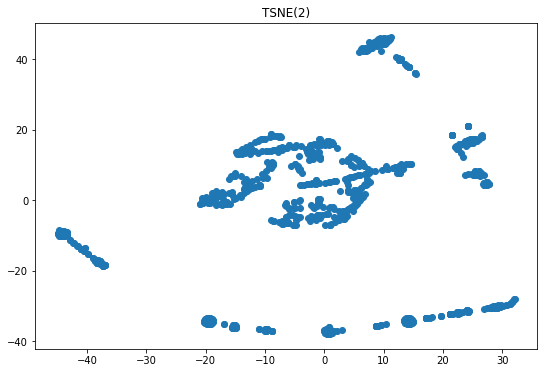

In [10]:
#TSNE(2) == StandardScaler( TSNE(2) )
# x, y = list(zip(*StandardScaler().fit_transform(TSNE(n_components=2, random_state=0).fit_transform(X_train[:900]))))
x, y = list(zip(*(TSNE(n_components=2, random_state=0).fit_transform(X_train[:900]))))

plt.figure(figsize=(9, 6))
plt.scatter(x, y)
plt.title('TSNE(2)')
plt.show()

Text(0.5, 0.92, 'TSNE(3)')

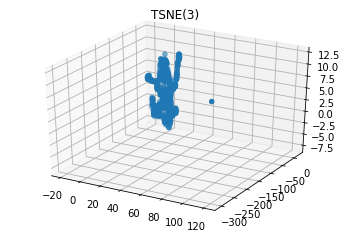

In [11]:
#TSNE(3)
data = TSNE(n_components=3, random_state=12).fit_transform(X_train[:900])
x, y, z = list(zip(*data))

fig = pylab.figure()
ax = fig.add_subplot(111, projection = '3d')
plt.title('TSNE(3)')
sc = ax.scatter(x,y,z)

<Figure size 648x432 with 0 Axes>

Text(0.5, 1.0, 'PCA(2)')

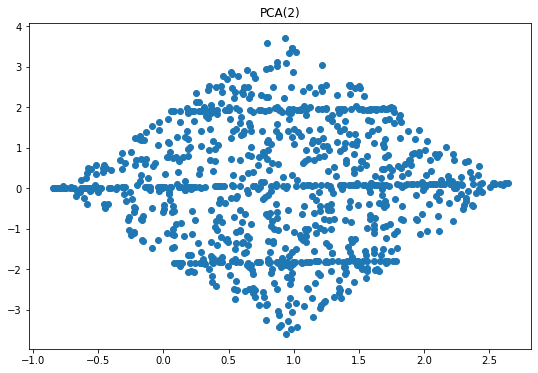

In [12]:
# PCA(2)
x, y = list(zip(*StandardScaler().fit_transform(PCA(2).fit_transform(X_train[:2000]))))

plt.figure(figsize=(9, 6))
plt.scatter(x, y)
plt.title('PCA(2)')
plt.show()

Text(0.5, 0.92, 'PCA(3)')

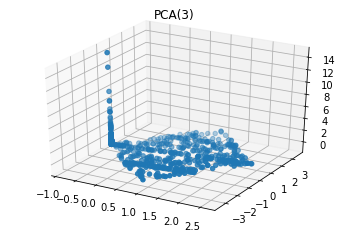

In [13]:
# PCA(3)
x, y, z = list(zip(*StandardScaler().fit_transform(PCA(3).fit_transform(X_train[:900]))))

fig = pylab.figure()
ax = fig.add_subplot(111, projection = '3d')
plt.title('PCA(3)')
sc = ax.scatter(x,y,z)

## On to the Intrusion Detection

In [14]:
DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=25, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_features='auto', bootstrap=False)

eclf = VotingClassifier(estimators=[('lr', DTC), ('rf', RFC),('et',ETC)], voting='hard') 
for clf, label in zip([DTC, RFC,ETC, eclf], ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'Ensemble']): 
    _ = eclf.fit(X_train,y_train)
    pred = eclf.score(X_test,y_test)
    print("Acc: %0.10f [%s]" % (pred,label))

Acc: 0.8102714031 [DecisionTreeClassifier]
Acc: 0.8102610540 [RandomForestClassifier]
Acc: 0.8104111148 [ExtraTreesClassifier]
Acc: 0.8098056971 [Ensemble]


 ## Grab some ensemble 
 [github.com/alik604/The-Best-Ensemble](github.com/alik604/The-Best-Ensemble)

In [15]:
import xgboost
import lightgbm

DTC = DecisionTreeClassifier()
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
XGB = xgboost.XGBClassifier(n_estimators=100, n_jobs=-1)
GBM = lightgbm.LGBMClassifier(objective='multiclass', n_estimators= 500)

list_of_CLFs_names = []
list_of_CLFs = [DTC, RFC, ETC, XGB, GBM]
ranking = []

for clf in list_of_CLFs:
    _ = clf.fit(X_train,y_train)
    pred = clf.score(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

Acc: 0.78767 for the DecisionTreeClassifier
Acc: 0.81760 for the RandomForestClassifier
Acc: 0.81248 for the ExtraTreesClassifier
Acc: 0.82636 for the XGBClassifier
Acc: 0.82420 for the LGBMClassifier


In [16]:
best = max(ranking)
avg = sum(ranking)/len(ranking)
variance = avg - best
to_remove = ranking - avg - variance
to_remove_alt = ranking - best - variance
print(list_of_CLFs_names)
print(to_remove)
print(to_remove_alt)
ranking = np.array(ranking)[to_remove > 0]
list_of_CLFs = np.array(list_of_CLFs)[to_remove > 0]


eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, refit=False, voting='soft')
_ = eclf.fit(X_train, y_train)
pred = eclf.score(X_test, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))

['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'XGBClassifier', 'LGBMClassifier']
[-0.01329228  0.01663709  0.01151432  0.02539236  0.02322941]
[-0.02598846  0.00394091 -0.00118186  0.01269618  0.01053323]
Acc: 0.82408 for the EnsembleVoteClassifier


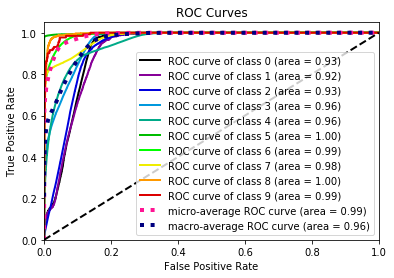

,0,1,2,3,4,5,6,7,8,9
out,Analysis,Backdoor,DoS,Exploits,Fuzzers,Generic,Normal,Reconnaissance,Shellcode,Worms


In [17]:
pred = eclf.predict(X_test)
probas = eclf.predict_proba(X_test)
scikitplot.metrics.plot_roc(y_true=y_test, y_probas=probas) # 
plt.show()

pd.DataFrame({'out': le_attack_cat.inverse_transform([0,1,2,3,4,5,6,7,8,9])}).T

## Using PYOD & SUOD
https://github.com/yzhao062/PYOD

https://github.com/yzhao062/SUOD

In [ ]:
from suod.models.base import SUOD
from pyod.models import lof, cblof, cof, pca, iforest, knn, mcd, ocsvm, sod, abod, hbos #, auto_encoder, vae

# initialize a set of base outlier detectors to train and predict on
base_estimators = [
#     knn.KNN(n_neighbors=5,  contamination=contamination, radius=1.5),
    knn.KNN(n_neighbors=15, contamination=contamination, radius=1.5),
    knn.KNN(n_neighbors=25, contamination=contamination, radius=1.5),
#     lof.LOF(n_neighbors=5,  contamination=contamination),
    lof.LOF(n_neighbors=15, contamination=contamination),
    lof.LOF(n_neighbors=25, contamination=contamination),
    cblof.CBLOF(contamination=contamination, n_clusters=45),
    hbos.HBOS(contamination=0.01, n_bins=10, tol=0.1),
    pca.PCA(contamination=contamination),
    iforest.IForest(contamination=contamination, n_estimators=300, max_samples=1028),
    mcd.MCD(contamination=contamination),
    ocsvm.OCSVM(contamination=contamination, ),
    abod.ABOD(contamination=contamination, n_neighbors=10),
                    ## not compatible
#     cof.COF(contamination=contamination),
#     sod.SOD(contamination=contamination, n_neighbors=25),
]

# initialize a SUOD model with all features turned on
model = SUOD(base_estimators=base_estimators, n_jobs=6,  # number of workers
             rp_flag_global=True,  # global flag for random projection
             bps_flag=True,  # global flag for balanced parallel scheduling
             approx_flag_global=False,  # global flag for model approximation
             contamination=contamination)

model.fit(X_train)  # fit all models with X
model.approximate(X_train)  # conduct model approximation if it is enabled
predicted_labels = model.predict(X_train)  # predict labels
predicted_probs = model.predict_proba(X_train)  # predict outlying probability
predicted_scores = model.decision_function(X_train)  # predict scores

Worker 1 sum of ranks: 3.5384615384615383
Worker 2 sum of ranks: 4.846153846153846
Worker 3 sum of ranks: 3.923076923076923
Worker 4 sum of ranks: 3.769230769230769
Worker 5 sum of ranks: 3.9230769230769234
Worker 6 sum of ranks: 0.0

Split among workers BPS: [0, 2, 5, 8, 11, 13, 13] [2, 3, 3, 3, 2, 0]
Parallel Training...


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:   11.3s remaining:   22.8s


In [ ]:
# how many CLFs voted for datapoint to be considered "Evil", INDEX
sum_by_row = np.sum(model.predict(X_train), axis=1) 
data = np.sort(sum_by_row)
data_idx = np.argsort(sum_by_row)

tuples = zip(data, data_idx) ## doesn't copy the elements of these two sequences, but generates a new set of references to these
sorted_tuples = sorted(tuples, key = lambda tup: tup[0], reverse=True)

sorted_tuples = [tup for tup in sorted_tuples if tup[0] != 0]
print('Format: (#Votes to CLF as "Evil", INDEX)', sorted_tuples)
print('Average Votes as "Evil", per "Evil" point', np.mean(sum_by_row[sum_by_row != 0]))

In [ ]:
MIN_NUMBER_VOTES = 4
indexs = [sorted_tuples[i][1] for i in range(len(sorted_tuples)) if sorted_tuples[i][0] >= MIN_NUMBER_VOTES]
# df = pd.DataFrame(X_train[indexs], columns = columns)
df = X_train.iloc[indexs]

In [ ]:
iforest_clf = iforest.IForest(contamination=contamination, n_estimators=300, max_samples= 1028, n_jobs=-1)
_ = iforest_clf.fit(X_train)
pred = iforest_clf.predict_proba(X_train)

In [ ]:
from pyod.models import so_gaal, auto_encoder, vae
data = X_train
dim = X_train.shape[1]

model = vae.VAE(contamination=contamination, encoder_neurons=[dim, dim-1],decoder_neurons=[dim-1,dim],  ) 
_ = model.fit(data)
pred = model.predict(X_train)